## Notebook for collating metadata and analysed data from all experiments and plotting the results

In [1]:
%run ./rob_setup_notebook.ipynb

import utils.interareal_plotting as ip

try:
    with open(master_path, 'rb') as f:
        master_obj = pickle.load(f)
except: 
    raise Exception('ERROR: Could not load master pickle')


Suite2p path: ['/home/rlees/Documents/Code/suite2p/suite2p']
QNAP_path: /home/rlees/mnt/qnap 
QNAP_data_path /home/rlees/mnt/qnap/Data 
Pickle folder: /home/rlees/mnt/qnap/pkl_files 
Master pickle: /home/rlees/mnt/qnap/master_pkl/master_obj.pkl 
Figure save path: /home/rlees/mnt/qnap/Analysis/Plots 
STA movie save path: /home/rlees/mnt/qnap/Analysis/STA_movies 
S2 borders path: /home/rlees/mnt/qnap/Analysis/S2_borders


### See the variables that are attributed to the master object

In [2]:
print('Attributes of master object:', end='\n\n')
for key, value in vars(master_obj).items():
    print(key)

Attributes of master object:

pkl_folder
pkl_name
pkl_path
n_units
n_targets
n_targeted_cells
targeted_cells
s1_cells
stim_dur
stim_freq
stim_type
sheet_name
tiff_path
fps
df
new_pkls
temp_df


### Add new pickle files to the master object

In [6]:
master_obj.addPickles()

with open(master_path, 'wb') as f:
    pickle.dump(master_obj, f)

### Create master object and collate all analysis from individual experiments

In [18]:
master_obj = ip.interarealPlotting(pkl_folder)

with open(master_path, 'wb') as f:
    pickle.dump(master_obj, f)

### Plot summary statistics and other analytics

Plotting summary statistic for all experiments: target_sta_amp
Plotting summary statistic for all experiments: target_responders_sta
Plotting summary statistic for all experiments: s2_sta_amp
Plotting summary statistic for all experiments: positive_s2_responders_sta
Plotting summary statistic for all experiments: stim_freq
Plotting stimulus triggered average for all experiments: target_sta


No handles with labels found to put in legend.


Plotting reliable responders (STA) for S1 vs S2: ['target_responders_sta', 'positive_s2_responders_sta']

Number of cells responding out of total targeted:
2019-11-14_J061
Similar: 7 out of 23
Random: 13 out of 19
2019-11-14_J063
Similar: 2 out of 12
Random: 12 out of 19
2019-11-15_J064
Similar: 9 out of 25
Random: 17 out of 26
2019-11-18_J065
Similar: 6 out of 24
Random: 5 out of 18
2020-02-27_RL075
Similar: 16 out of 33
Random: 22 out of 35
2020-03-03_RL074
Similar: 28 out of 38
Random: 16 out of 23
2020-03-05_RL070
Similar: 4 out of 16
Random: 11 out of 20
2020-03-05_RL072
Similar: 12 out of 27
Random: 21 out of 33
2020-03-12_RL070
Similar: 3 out of 20
Random: 4 out of 11
2020-03-16_RL074
Similar: 6 out of 13
Random: 7 out of 13
2020-03-19_RL075
Similar: 3 out of 17
Random: 2 out of 9


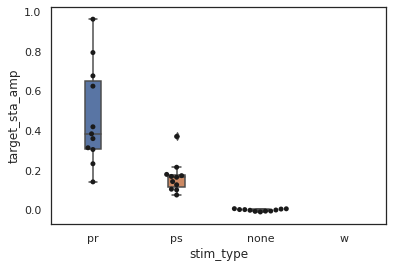

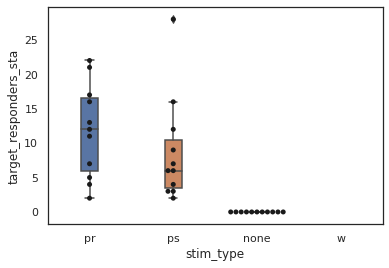

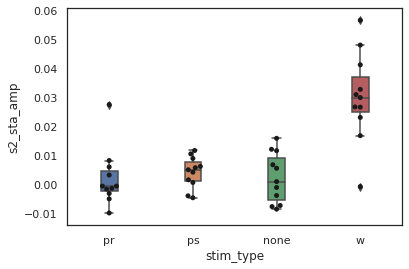

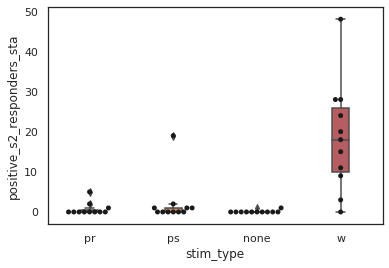

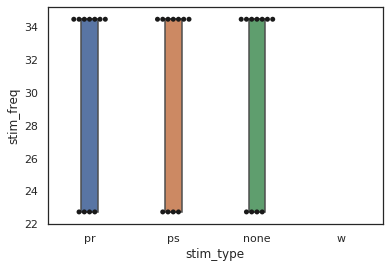

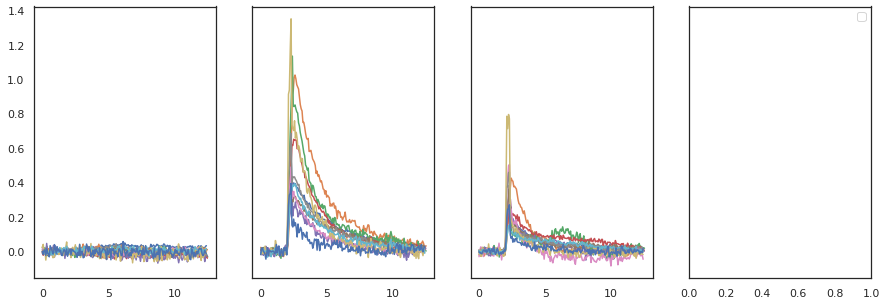

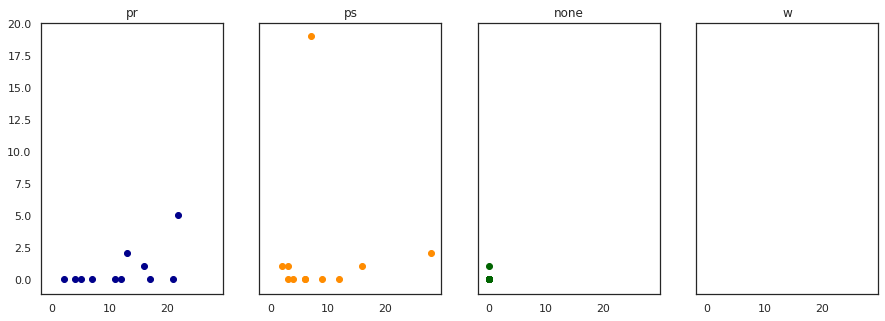

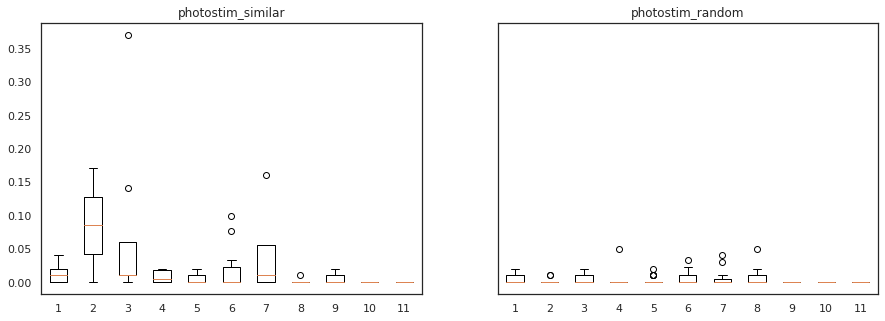

In [30]:
with open(master_path, 'rb') as f:
    master_obj = pickle.load(f)

# Plot probability of response on whisker trials for 'ps' and 'pr' target responders
# master_obj.plotWhiskerBias()
    
# Plot mean STA dFF amplitude across all cells in group
master_obj.boxplotSummaryStat('target_sta_amp')
master_obj.boxplotSummaryStat('target_responders_sta')
# plt.savefig(os.path.join(fig_save_path, 'target_sta_amp.svg'))
# master_obj.boxplotSummaryStat('non_target_sta_amp')
master_obj.boxplotSummaryStat('s2_sta_amp')
master_obj.boxplotSummaryStat('positive_s2_responders_sta')
master_obj.boxplotSummaryStat('stim_freq')


# plt.savefig(os.path.join(fig_save_path, 'positive_s2_responders_sta.svg'))

# Plot distribution of STA amplitudes across all cells in group
# master_obj.distributionSummaryStat('s2_sta')

# Plot mean STA dFF trace across all cells in group
master_obj.lineplotSTA('target_sta')
# plt.savefig(os.path.join(fig_save_path, 'target_sta.svg'))
# master_obj.lineplotSTA('non_target_sta')
# master_obj.lineplotSTA('s2_sta')

# Plot probability of response for each stim separately for each animal
# master_obj.boxplotProbResponse(to_mask='target_cells')
# plt.savefig(os.path.join(fig_save_path, 'prob_response_boxplot.svg'))

# Plot probability of response for each cell across two different stim types
# master_obj.scatterProbResponse(to_mask='target_cells')
# plt.savefig(os.path.join(fig_save_path, 'prob_response_scatter.svg'))

# Plot reliable responders over 100 trials (STA)
master_obj.scatterResponseSTA(['target_responders_sta', 'positive_s2_responders_sta'], proportion=False)
# master_obj.scatterResponseSTA(['positive_s1_responders_sta', 'positive_s2_responders_sta'], proportion=True)

# Plot all responders per trial (> 2 S.D. of baseline)
# master_obj.scatterResponseTrial(['target_responders_trial_sum', 'positive_s2_responders_trial'], proportion=True)
# master_obj.scatterResponseTrial(['target_responders_trial_sum', 'positive_s2_responders_trial'])
# master_obj.scatterResponseTrial(['positive_s1_responders_trial', 'positive_s2_responders_trial'], proportion=True)
# master_obj.scatterResponseTrial(['positive_s1_responders_trial', 'positive_s2_responders_trial'])
# master_obj.scatterResponseTrial(['target_sum_dff', 'positive_s2_responders_trial'])
# master_obj.scatterResponseTrial(['num_whisker_targets', 'positive_s2_responders_trial'])
# master_obj.scatterResponseTrial(['euclid_dist', 'positive_s2_responders_trial'])

# Plot whisker bias of targets
master_obj.boxplotWhiskerBias()

In [21]:
master_obj.df

,sheet_name,tiff_path,stim_type,fps,n_units,s1_cells,s2_sta,s2_sta_amp,s2_sta_std,s1_sta,...,non_target_sta_amp,non_target_sta_std,target_responders_trial,target_responders_trial_sum,target_responders,target_responders_sta,target_responders_sta_nomulti,target_sum_dff,num_whisker_targets,euclid_dist
0,2020-03-03_RL074,2020-03-03_RL074_t-005,pr,15.230163,703,"[True, True, True, True, True, True, True, Tru...","[0.0031109538, 0.0034287437, 0.0014365749, 0.0...",-0.000849,"[0.054167558, 0.054008517, 0.053149097, 0.0556...","[0.005409178, 0.00535365, 0.002886082, 0.00245...",...,-0.001064,"[0.046492606, 0.04539982, 0.043628197, 0.04481...","[[False, False, False, False, False, False, Fa...","[8, 9, 8, 8, 9, 9, 8, 9, 7, 6, 7, 10, 5, 7, 6,...","[False, False, False, False, False, False, Fal...",16.0,18.0,"[7.966341972351074, 11.889556884765625, 7.9293...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[108.73176930524951, 106.79750366990538, 132.2..."
1,2020-03-03_RL074,2020-03-03_RL074_t-006,ps,15.231754,703,"[True, True, True, True, True, True, True, Tru...","[-0.0040993835, -0.0010641889, -0.0029521757, ...",0.008712,"[0.04905566, 0.057080325, 0.05153678, 0.054075...","[0.0024088053, 0.00022200601, 0.000620996, -0....",...,0.007588,"[0.042048946, 0.045095578, 0.04363049, 0.04513...","[[False, False, False, False, False, False, Fa...","[10, 9, 8, 7, 5, 8, 7, 4, 7, 6, 5, 7, 6, 5, 4,...","[False, False, False, False, False, True, Fals...",28.0,31.0,"[6.9609222412109375, 4.386020660400391, 5.1117...","[2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...","[76.58736841020195, 55.90031913157874, 39.0164..."
2,2020-03-03_RL074,2020-03-03_RL074_t-003,none,15.230604,703,"[True, True, True, True, True, True, True, Tru...","[0.009362724, 0.00066977757, 0.0038684062, 0.0...",0.000701,"[0.049859077, 0.051333673, 0.04705506, 0.04875...","[0.0057592755, 0.0022232665, 0.0059273452, 0.0...",...,0.002325,"[0.041794337, 0.04424401, 0.03983839, 0.042031...","[[False, False, False, False, False, False, Fa...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, ...","[False, False, False, False, False, False, Fal...",0.0,0.0,"[0.0, 0.45311790704727173, 0.0, 0.0, 0.0, 0.85...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2020-03-03_RL074,2020-03-03_RL074_t-002,w,15.230931,703,"[True, True, True, True, True, True, True, Tru...","[0.006183277, 0.0018097654, 0.005314444, 0.006...",0.030805,"[0.047885686, 0.054592732, 0.054738447, 0.0490...","[0.00015742732, 0.0021277545, 0.003113842, 0.0...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-11-14_J061,2019-11-14_J061_t-007,pr,15.023208,694,"[False, False, True, False, True, False, False...","[-0.0035995662, -8.893233e-05, -0.0031696053, ...",0.002970,"[0.045801684, 0.045892935, 0.05103566, 0.04407...","[-0.0014210643, -0.006463312, 0.0032900875, 0....",...,0.001375,"[0.054713618, 0.063870504, 0.06284379, 0.05863...","[[False, False, False, False, False, False, Fa...","[8, 9, 8, 7, 7, 8, 10, 7, 8, 6, 7, 7, 6, 7, 6,...","[False, False, False, False, False, False, Fal...",13.0,16.0,"[27.05085563659668, 20.185047149658203, 21.338...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[110.14856799454998, 125.19540282649719, 139.2..."
5,2019-11-14_J061,2019-11-14_J061_t-006,ps,15.220141,694,"[False, False, True, False, True, False, False...","[-0.0028110463, 0.0019551192, -0.0025470764, -...",0.011467,"[0.043860935, 0.04805295, 0.04555415, 0.049317...","[0.00027603534, 0.0012205804, -0.0042518615, 0...",...,0.001365,"[0.062030226, 0.06534852, 0.06338191, 0.060595...","[[False, False, False, False, False, False, Fa...","[4, 5, 4, 3, 4, 5, 4, 4, 3, 5, 3, 4, 6, 4, 3, ...","[False, False, False, False, False, False, Fal...",7.0,11.0,"[9.304707527160645, 12.051961898803711, 11.078...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[71.94235974028096, 43.202314752799985, 71.942..."
6,2019-11-14_J061,2019-11-14_J061_t-003,none,15.222459,694,"[False, F